## Combining node and constraint detection

In this notebook the advances made in the previous chapters are combined to not only show the nodes, but also the constraints of an image.

At first both models have to be loaded.

In [1]:
from os import path

import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
symbol_detector_path = path.join('models', 'devel', 'fcn_sym_det.h5')
symbol_detector = tf.keras.models.load_model(symbol_detector_path)

symbol_detector.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
dense (Conv2D)               (None, None, None, 3)     6147      
Total params: 14,643
Trainable params: 14,643
Non-trainable params: 0
_________________________________________________________

In [3]:
crop_detector_path = path.join('models', 'devel', 'crop_detector.h5')
crop_detector = tf.keras.models.load_model(crop_detector_path)

crop_detector.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 55299 

Then images have to be loaded, which are used to test the models.

The second step of the interim data contains images of nodes which are connected with constraints, so 5 images of that dataset are loaded. 

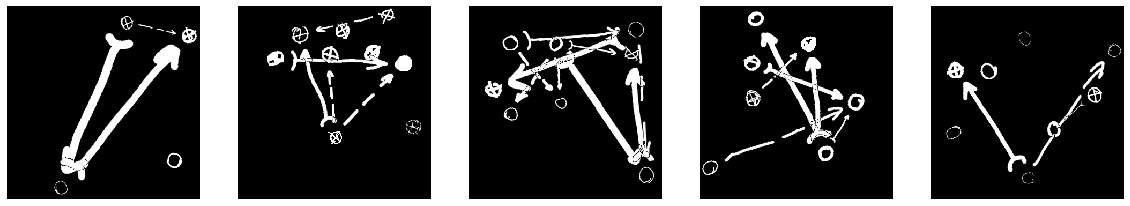

In [4]:
image_dir = path.join('data', 'sep_interim_02')

image_paths = [path.join(image_dir, str(i)+'.png') for i in range(5)]
images = [cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in image_paths]

plt.figure(figsize=(20,20))

for idx, image in enumerate(images):
    plt.subplot(1, 5, idx + 1)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(image)

plt.show()

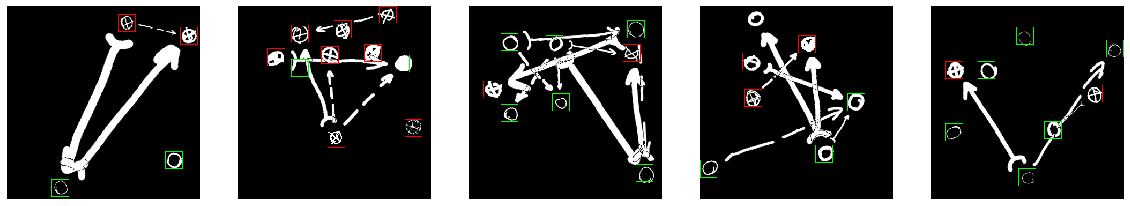

In [5]:
def get_bounding_boxes_nms(predictions):
    sqz = tf.squeeze
    max_idx = tf.math.argmax(sqz(predictions), -1)
    node_idx = tf.where(tf.equal(max_idx, 1))
    base_idx = tf.where(tf.equal(max_idx, 2))
    all_idx = tf.concat([node_idx, base_idx], 0)

    max_val = tf.math.reduce_max(sqz(predictions), -1)
    
    y, x = tf.split(all_idx * 4, 2, -1)

    coords = sqz(tf.stack([y, x, y + 32, x + 32], -1))
    all_boxes = tf.cast(coords / 360, tf.float32)

    scores = tf.gather_nd(max_val, all_idx)
    eps = tf.keras.backend.epsilon()
    nms_idx = tf.image.non_max_suppression(all_boxes, scores, 99, eps, 0.8)

    limit = tf.cast(tf.math.count_nonzero(node_idx, 0)[0], tf.int32)
    mask = tf.less(nms_idx, limit)
    node_mask = tf.boolean_mask(nms_idx, mask)
    base_mask = tf.boolean_mask(nms_idx,~mask)

    node_boxes = tf.gather(all_boxes, node_mask)
    base_boxes = tf.gather(all_boxes, base_mask)

    return node_boxes, base_boxes

image_tensor = tf.convert_to_tensor(images)
image_tensor = tf.cast(image_tensor / 255, tf.float32)
image_tensor = tf.expand_dims(image_tensor, -1)

node_pred = symbol_detector(image_tensor)

boxes = [get_bounding_boxes_nms(pred) for pred in node_pred]

image_rgb = tf.image.grayscale_to_rgb(image_tensor)

plt.figure(figsize=(20,20))

save_images = []
for idx, image in enumerate(image_rgb):
    image = tf.expand_dims(image, 0)
    image = tf.image.draw_bounding_boxes(
        image, [boxes[idx][0]], [[0, 1, 0]])
    image = tf.image.draw_bounding_boxes(
        image, [boxes[idx][1]], [[1, 0, 0]])
    plt.subplot(1, 5, idx + 1)
    plt.set_cmap('hsv')
    plt.axis('off')
    image = tf.squeeze(image)
    plt.imshow(image)
    save_images.append(image.numpy())

plt.show()

The accuracy is okay.
Considering the fact that there are a lot of fragments in the form of constraints in these images, only one node is detected at a point where no node should be (second image, the left (wrong) node detection).
The node in the fourth image is actually detected, but the bounding box is not visible for some reason...

The next step is to crop the image between the nodes.

This code has a lot of parts of `2.2.3-extracting_crops.ipynb`, which is not surprising, considering the fact that the same operations have to be performed.

The information needed at this point are the crop images taken from the images, which are in a list of lists, assigning the crops to the image by their index and a corresponding list containing the coordinates of the crops to be able to identify the position of the prediction later on.

To be able to perform the cropping in the first place the position of the nodes has to be identified.
We already have the information needed to generate bounding boxes.
The middle point of each bounding box is therefore considered to be the center of the nodes.

In [6]:
box_coords = []
for box in boxes:
    blob = tf.concat([box[0], box[1]], 0)
    blob *= 360
    blob = tf.cast(blob, tf.int32)
    box_coords.append(
        [[int((i[0]+i[2])/2),int((i[1]+i[3])/2)] for i in blob])

crops = []
crops_info = []
for idx, coords in enumerate(box_coords):
    image_crop = []
    image_info = []
    for node1 in coords:
        for node2 in coords:
            x1 = min(node1[1], node2[1])
            y1 = min(node1[0], node2[0])
            x2 = max(node1[1], node2[1])
            y2 = max(node1[0], node2[0])
            # Remove images with area 0
            if x1 == x2 or y1 == y2:
                continue

            crop = images[idx][y1:y2, x1:x2]
            crop = cv2.resize(crop, (96, 96))

            if x1 == node2[1]:
                x1 = node1[1]
                x2 = node2[1]
                crop = cv2.flip(crop, 1)
            if y1 == node2[0]:
                y1 = node1[0]
                y2 = node2[0]
                crop = cv2.flip(crop, 0)

            crop = tf.expand_dims(crop, -1)
            crop = tf.cast(crop / 255, tf.float32)

            image_crop.append(crop)
            image_info.append([x1, y1, x2, y2])

    crops.append(image_crop)
    crops_info.append(image_info)

crop_pred = [crop_detector(tf.convert_to_tensor(crop)) for crop in crops]

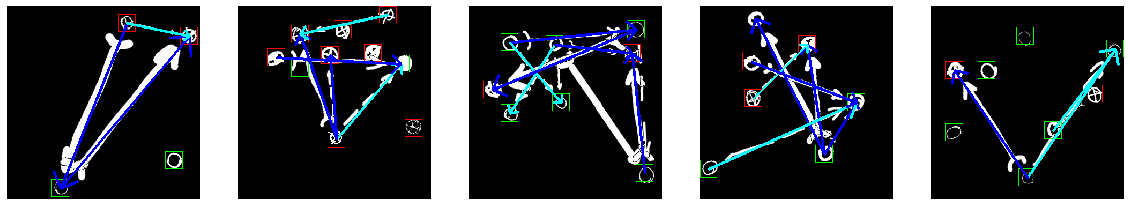

In [7]:
for idx, pred in enumerate(crop_pred):
    for jdx, argmax in enumerate(tf.argmax(pred, -1)):
        if argmax == 0:
            continue
        x1, y1, x2, y2 = crops_info[idx][jdx]
        color = (0, int(argmax - 1), 1)
        cv2.arrowedLine(save_images[idx], (x1, y1), (x2, y2),color , 3)

plt.figure(figsize=(20,20))

save_path = path.join('reports', 'sep', 'images')
for idx, image in enumerate(save_images):
    plt.subplot(1, 5, idx + 1)
    plt.set_cmap('hsv')
    plt.axis('off')
    plt.imshow(image)
    image_path = path.join(save_path, '225_' + str(idx) + '.png')
    cv2.imwrite(image_path, 255 - image * 255)

plt.show()

The results do seem to be okay, actually.
Most constraints are detected and where they are not, the environment is often cluttered.
The performance is not perfect though, but as a first proof of concept this should suffice.

A take away is that crop detection relies heavily on the performance of the node detection, because nodes which are not detected are not taken into account when creating the data for the `crop_detector`.

Falsely predicted nodes are most likely not going to result in a pair of nodes connected by constraints, but they are slowing the process down significantly, since the number of crops grows exponentially to the number of nodes.

By taking the coordinates of the nodes and subsequentially pairs of nodes which share a constraint, all necessary information is needed to be able to create a model of a mechanism.